# Evolving a Lunar Lander with differentiable Genetic Programming

## Installation
To install the required libraries run the command:

In [54]:
#test change
!pip install -r requirements.txt

## Imports
Imports from the standard genepro-multi library are done here. Any adjustments (e.g. different operators) should be made in the notebook. For example:

```
class SmoothOperator(Node):
  def __init__(self):
    super(SmoothOperator,self).__init__()
    self.arity = 1
    self.symb = "SmoothOperator"

  def _get_args_repr(self, args):
    return self._get_typical_repr(args,'before')

  def get_output(self, X):
    c_outs = self._get_child_outputs(X)
    return np.smoothOperation(c_outs[0])

  def get_output_pt(self, X):
    c_outs = self._get_child_outputs_pt(X)
    return torch.smoothOperation(c_outs[0])
```

In [55]:
%reload_ext autoreload
%autoreload 2
import importlib
import genepro
importlib.reload(genepro)

import gymnasium as gym

from genepro.node_impl import *
from genepro.evo import Evolution
from genepro.node_impl import Constant
from genepro.variation import *
from genepro.selection import tournament_selection

import torch
import torch.optim as optim

import random
import os
import copy
from collections import namedtuple, deque

import matplotlib.pyplot as plt
from matplotlib import animation

import time

In [56]:
#workaround for error 15:
#OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Reinforcement Learning Setup
Here we first setup the Gymnasium environment. Please see https://gymnasium.farama.org/environments/box2d/lunar_lander/ for more information on the environment. 

Then a memory buffer is made. This is a buffer in which state transitions are stored. When the buffer reaches its maximum capacity old transitions are replaced by new ones.

A frame buffer is initialised used to later store animation frames of the environment.

In [57]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [58]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity): #specifies the max length of the memory buffer by making deque() object
        self.memory = deque([], maxlen=capacity)

    def push(self, *args): #pushes new transition(state,action,nextstate, reward) onto memory
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size): #returns sample batch of transitions in memory
        return random.sample(self.memory, batch_size)

    def __len__(self): #returns current length of the memory
        return len(self.memory)

    def __iadd__(self, other): #changes and returns the existing memory
      self.memory += other.memory
      return self 

    def __add__(self, other): #leaves existing memory but creates and returns new combined memory
      self.memory = self.memory + other.memory 
      return self

In [59]:
frames = []

## Fitness Function

Here you get to be creative. The default setup evaluates 5 episodes of 300 frames. Think of what action to pick and what fitness function to use. The Multi-tree takes an input of $n \times d$ where $n$ is a batch of size 1.

In [60]:
def fitness_function_pt(multitree, num_episodes=5, episode_duration=300, render=False, ignore_done=False):
  memory = ReplayMemory(10000)
  rewards = []

  for _ in range(num_episodes):
    # get initial state of the environment
    observation = env.reset() #resets to initial state (first seed is chosen randomly, then stays the same)
    observation = observation[0] #returns metric(?) of first observation
    
    for _ in range(episode_duration):
      if render:
        frames.append(env.render())

      input_sample = torch.from_numpy(observation.reshape((1,-1))).float() #creates a tensor from a numpy array (shared memory)
      
      # what goes here? TODO
      action = None
      #old definition(could be a hint): 
      action = torch.argmax(multitree.get_output_pt(input_sample))
      observation, reward, terminated, truncated, info = env.step(action.item()) #updates environment with input action
      rewards.append(reward)
      output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      memory.push(input_sample, torch.tensor([[action.item()]]), output_sample, torch.tensor([reward]))
      if (terminated or truncated) and not ignore_done:
        break

  fitness = np.sum(rewards)
  
  return fitness, memory

## Evolution Setup
Here the leaf and internal nodes are defined. Think about the odds of sampling a constant in this default configurations. Also think about any operators that could be useful and add them here. 

Adjust the population size (multiple of 8 if you want to use the standard tournament selection), max generations and max tree size to taste. Be aware that each of these settings can increase the runtime.

In [61]:
num_features = env.observation_space.shape[0]
leaf_nodes = [Feature(i) for i in range(num_features)]
leaf_nodes = leaf_nodes + [Constant()] # Think about the probability of sampling a coefficient
internal_nodes = [Plus(),Minus(),Times(),Div()] #Add your own operators here

def generateEvo(rate_crossover=0.5, rate_mutation=0.5, rate_coeff=0.5, tournament_size=8):
  return Evolution(
    fitness_function_pt, internal_nodes, leaf_nodes,
    4,
    pop_size=16,
    max_gens=2,
    max_tree_size=31,
    n_jobs=8,
    verbose=True,
    crossovers=[{"fun":subtree_crossover, "rate": rate_crossover}],
    mutations=[{"fun":subtree_mutation, "rate": rate_mutation}],
    coeff_opts=[{"fun":coeff_mutation, "rate": rate_coeff}],
    selection={"fun":tournament_selection,"kwargs":{"tournament_size":tournament_size}}
    )

colours = ['b', 'r', 'y', 'g', "#940D77"]
crossover_rates = [0.9, 0.7, 0.5, 0.3, 0.1]
mutation_rates = [0.9, 0.7, 0.5, 0.3, 0.1]
coeff_rates = [0.9, 0.7, 0.5, 0.3, 0.1]
tournament_sizes = [8, 16, 32, 56, 128]


## Evolve
Running this cell will use all the settings above as parameters

In [62]:
def evolve_all(experiment, evos):
    print(experiment)
    for i, e in enumerate(evos):
        start_time = time.time()
        e[0].evolve()
        end_time = time.time()
        comp_time = end_time-start_time
        print(f"Computation time rate: {e[1]}: {comp_time} seconds")

# Test

In [63]:
def get_test_score(tree):
    rewards = []

    for i in range(5): #run 5 episodes for baseline
      # get initial state
      observation = env.reset(seed=i)
      observation = observation[0]

      for _ in range(300): #300 time steps for baseline
        # build up the input sample for GP
        input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        # get output (squeezing because it is encapsulated in an array)
        output = tree.get_output_pt(input_sample)
        action = torch.argmax(output) # What goes here?
        observation, reward, terminated, truncated, info = env.step(action.item())
        rewards.append(reward)


        output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        if (terminated or truncated):
            break

    fitness = np.sum(rewards)
    
    return fitness

In [64]:
def avg_reward_plot(evos):
    fig, ax = plt.subplots()
    for j, e in enumerate(evos):
        gen = range(len(e[0].best_of_gens)) #generation
        avg_rewards = [] #average reward
        for i in e[0].best_of_gens:
            avg_reward = get_test_score(i)/5
            avg_rewards.append(avg_reward)

        #plot generation vs fitness
        ax.plot(gen,avg_rewards,label=f"rate={e[1]}")
        best = e[0].best_of_gens[-1]
        print(best.get_readable_repr())
        print(get_test_score(best))

    ax.set_xlabel('Generation')
    ax.set_ylabel('Average Reward')
    ax.set_title('Average reward gained for five episodes by generation')

    plt.legend()
    plt.show()   

In [65]:
import statistics

def percent_plot(evos):
    fig2, ax2 = plt.subplots()
    for j, e in enumerate(evos):
        gen = range(e[0].num_gens) #generation

        medians = []
        percentile25 = []
        percentile75 = []

        for gen_pop_fitness in e[0].results:
            medians.append(statistics.median(gen_pop_fitness))
            qs = statistics.quantiles(gen_pop_fitness, n=4)
            percentile75.append(qs[0])
            percentile25.append(qs[-1])
        
        #plot generation vs fitness
        ax2.plot(gen,medians,label=f"rate={e[1]}")
        ax2.fill_between(gen, percentile25, percentile75, color=colours[j], alpha=.1)

    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Fitness')
    ax2.set_title('Fitness of median individual in population, spread from 75th to 25th quantile')

    plt.legend()
    plt.show()   

In [66]:
crossovers = []
for r in crossover_rates:
    crossovers.append([generateEvo(rate_crossover=r), r]) 

evolve_all("crossover rate", crossovers)

crossover rate
gen: 1,	best of gen fitness: -458.676,	best of gen size: 27
gen: 2,	best of gen fitness: -468.688,	best of gen size: 23
Computation time rate: 0.9: 19.525418043136597 seconds
gen: 1,	best of gen fitness: -538.092,	best of gen size: 23
gen: 2,	best of gen fitness: -530.236,	best of gen size: 29
Computation time rate: 0.7: 26.352980136871338 seconds
gen: 1,	best of gen fitness: -494.324,	best of gen size: 21
gen: 2,	best of gen fitness: -554.189,	best of gen size: 21
Computation time rate: 0.5: 18.699709177017212 seconds
gen: 1,	best of gen fitness: -483.194,	best of gen size: 21
gen: 2,	best of gen fitness: -520.170,	best of gen size: 27
Computation time rate: 0.3: 18.634262561798096 seconds
gen: 1,	best of gen fitness: -606.298,	best of gen size: 25
gen: 2,	best of gen fitness: -537.731,	best of gen size: 25
Computation time rate: 0.1: 23.300914764404297 seconds


['((x_7-x_1)/((x_5*x_1)*((x_4*x_4)*(x_6+x_1))))', '((((x_6*x_0)*x_5)-((x_4*x_6)+(x_5*x_5)))-(((x_7+x_3)*(x_0/x_4))/x_5))', '(((x_1-x_3)-(-0.285235196352005+x_1))+((x_2+(x_6/x_3))*((4.635806560516357-x_0)-(x_2*x_5))))', '((x_7-x_6)+(x_7+x_5))']
-581.4543218221072
['(((x_5/(x_2*(((x_3*x_5)-x_4)*(x_2-x_2))))+3.561950206756592)/(((x_4+x_7)*x_0)-((x_4-x_4)-(x_2+x_5))))', '((x_3/((x_3/x_4)+x_2))-((x_2/x_5)+(x_7/(x_6*x_5))))', 'x_2', '((((x_5/x_5)+(x_3+3.7888381481170654))-((x_0-x_2)*x_0))*((x_4+x_4)/((x_6-x_3)*x_7)))']
-568.7554961072926
['(((x_3/x_6)/(x_5+-1.9246134521240497))*((x_3+x_6)/(-3.21354603767395-(x_7-x_0))))', '(((x_1+(x_0-x_4))/(x_1*1.388990879058838))-((x_4+x_7)-(((x_2+-4.461772918701172)*x_6)*x_2)))', '((((x_4-x_0)*(x_3*x_6))*((x_0+x_0)*0.4288630783557892))+x_5)', '((x_4+((x_0+x_6)-(x_4*x_4)))-(((x_5*x_7)+x_1)+((x_3*x_0)+x_3)))']
-644.2839538626541
['((x_4-((x_6*x_6)-(x_3/x_2)))*(((x_7+x_2)-x_5)/((1.69524085521698/x_7)-(x_3+x_6))))', '((((x_1+-4.10029935836792)+(x_5-3.68033862

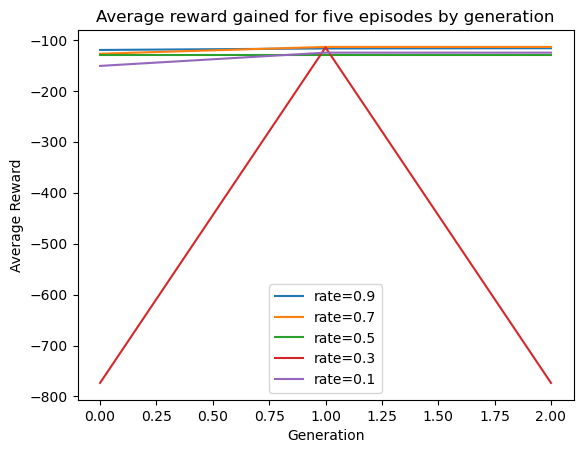

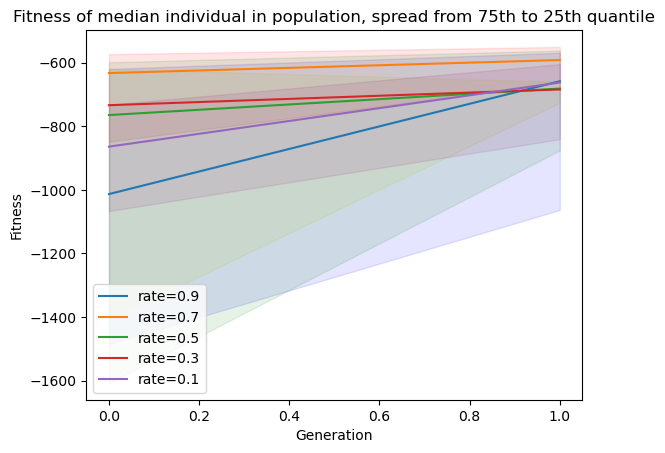

In [69]:
avg_reward_plot(crossovers)
percent_plot(crossovers)

In [71]:
mutations = []
for r in mutation_rates:
    mutations.append([generateEvo(rate_mutation=r), r]) 

evolve_all("mutation rate", mutations)

mutation rate
gen: 1,	best of gen fitness: -617.425,	best of gen size: 21
gen: 2,	best of gen fitness: -503.563,	best of gen size: 31
Computation time rate: 0.9: 14.993683338165283 seconds
gen: 1,	best of gen fitness: -559.727,	best of gen size: 27
gen: 2,	best of gen fitness: -516.812,	best of gen size: 27
Computation time rate: 0.7: 17.687437295913696 seconds
gen: 1,	best of gen fitness: -472.199,	best of gen size: 25
gen: 2,	best of gen fitness: -435.423,	best of gen size: 25
Computation time rate: 0.5: 17.37255024909973 seconds
gen: 1,	best of gen fitness: -496.523,	best of gen size: 25
gen: 2,	best of gen fitness: -532.870,	best of gen size: 25
Computation time rate: 0.3: 14.522920846939087 seconds
gen: 1,	best of gen fitness: -349.867,	best of gen size: 23
gen: 2,	best of gen fitness: -234.216,	best of gen size: 23
Computation time rate: 0.1: 15.055748462677002 seconds


['((((4.518563270568848+0.5658259987831116)*(x_0/x_7))/((x_4/x_6)-(-1.8906807899475098/x_7)))+(((x_4/x_5)/(x_7-x_7))+((3.2528858184814453-x_7)/(-4.332267761230469/x_6))))', '((((x_4+x_5)+x_5)/(x_4/x_7))+((x_4+(x_2-x_0))/(4.245178699493408-x_1)))', '((((x_2-x_7)-(-1.1285184621810913+x_1))-((3.6813698445044274*x_6)/(x_4/x_2)))/((x_5/(x_6-(x_1*x_1)))/(x_7-(x_0-x_5))))', '(((x_6/(x_4/x_7))+(x_3-x_6))/(((-1.2986997365951538--4.396602630615234)-((x_3*x_5)/x_7))*x_1))']
-645.1172123460425
['(((x_2*(x_0--2.598037004470825))-x_5)/((x_4-x_2)+((x_3*x_7)+(x_2-x_4))))', '(((x_4*(x_2*x_4))/((2.0481677055358887*x_3)/(x_3*x_6)))*(((4.307460784912109/x_2)/x_4)-((x_3+x_4)+(x_0*x_5))))', '(((x_6-(x_1*-2.4573473930358887))/((x_3+x_1)*x_5))+(((4.836387980084369-x_1)/x_7)*((x_3-x_6)-x_1)))', '((((x_4/x_1)+x_6)+x_6)*(((x_0*x_6)+x_2)/((x_6-1.932914137840271)+x_2)))']
-604.8123951696616
['(((x_2*x_5)-(x_4*(x_7-x_5)))+(((-0.6028544306755066--3.341379165649414)/x_6)+(x_7*x_4)))', '((x_7/((x_0-4.77377986907959)+(

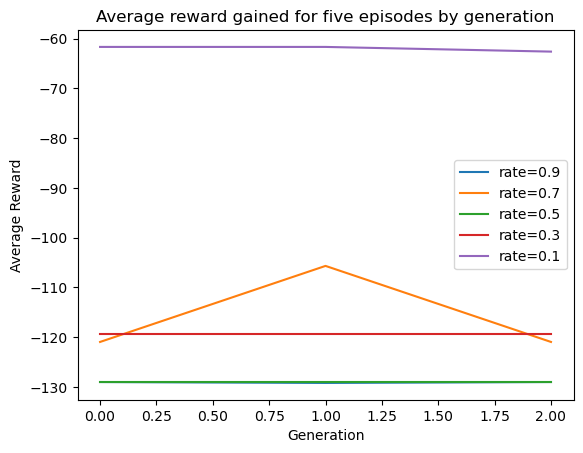

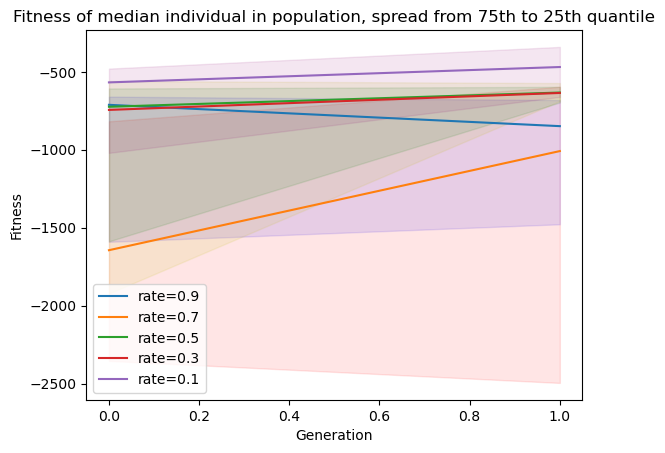

In [72]:
avg_reward_plot(mutations)
percent_plot(mutations)

In [73]:
coeffs = []
for r in coeff_rates:
    coeffs.append([generateEvo(rate_coeff=r), r]) 

evolve_all("coeffs rate", coeffs)

coeffs rate
gen: 1,	best of gen fitness: -478.558,	best of gen size: 31
gen: 2,	best of gen fitness: -306.827,	best of gen size: 31
Computation time rate: 0.9: 19.947481870651245 seconds
gen: 1,	best of gen fitness: -389.989,	best of gen size: 29
gen: 2,	best of gen fitness: -353.534,	best of gen size: 29
Computation time rate: 0.7: 17.977407693862915 seconds
gen: 1,	best of gen fitness: -536.764,	best of gen size: 23
gen: 2,	best of gen fitness: -508.734,	best of gen size: 23
Computation time rate: 0.5: 15.405836582183838 seconds
gen: 1,	best of gen fitness: -643.325,	best of gen size: 25
gen: 2,	best of gen fitness: -573.770,	best of gen size: 27
Computation time rate: 0.3: 17.251960039138794 seconds
gen: 1,	best of gen fitness: -309.832,	best of gen size: 19
gen: 2,	best of gen fitness: -497.826,	best of gen size: 31
Computation time rate: 0.1: 14.514665365219116 seconds


['(((3.728381872177124-x_5)-(x_2/(x_4*x_5)))/((x_7/(4.602010726928711-x_1))*((x_5-x_2)+(-1.0750815868377686/4.023342609405518))))', '((((x_4/x_0)-(x_3/-2.9736592537240187))-((x_2+x_0)-(-4.644553184509277/1.3821909427642822)))/(((x_1/x_5)+(x_3/x_1))+((x_3*x_2)-(3.2757036685943604-x_7))))', '((x_1+(x_0-x_6))*(((x_5/x_5)*(x_0-x_5))+((x_0/x_4)/3.1641907691955566)))', '(((x_0*1.2277483940124512)+((x_1-x_0)*(x_7/-4.648753643035889)))*(((x_1/x_3)/-0.34353846311569214)*((x_7-x_7)*x_4)))']
-668.3614017566672
['((((x_1+x_0)/(x_7/x_1))/((x_3+x_5)+x_2))*(((x_0-x_5)-x_7)/(x_5+(x_7*x_4))))', '((((x_0/x_7)-(x_1-x_4))/(x_7+-2.1579363346099854))+(((4.407439708709717*x_4)+(x_5*x_3))-(x_0-(x_2*x_7))))', '(((x_0-x_6)/(x_0*(x_5+x_6)))+(((-3.0775146484375*x_1)*x_3)/(x_6-(x_7/-2.499402761094992))))', '((((-0.30689889192581177-x_0)+(x_0+x_3))+((x_1/x_3)*(x_4/x_7)))+(((-4.936556339263916+x_3)-(-3.366352081298828-x_6))-(x_1-(x_2-x_7))))']
-854.4402175755218
['((x_1*(x_4*x_7))-((x_5*(x_3+x_6))+(x_3-x_1)))', '(((

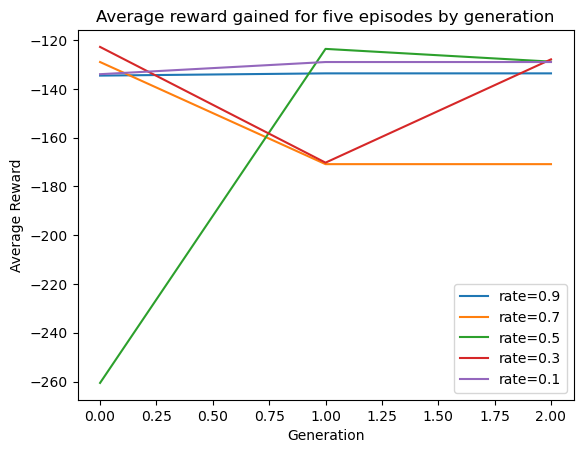

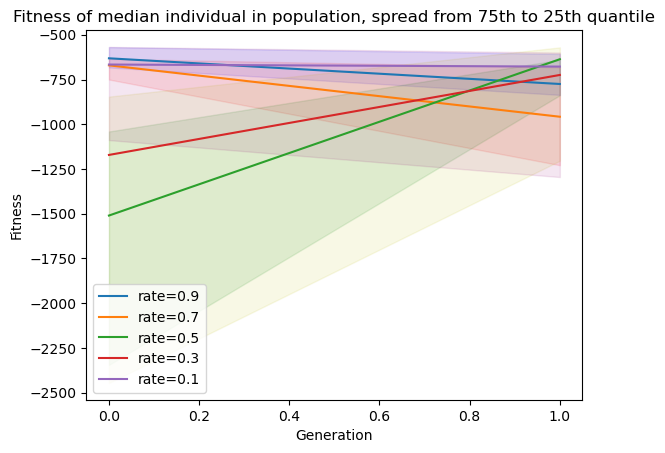

In [74]:
avg_reward_plot(coeffs)
percent_plot(coeffs)

## Make an animation
Here the best evolved individual is selected and one episode is rendered. Make sure to save your lunar landers over time to track progress and make comparisons.

In [ ]:
#test imagemagick
#!magick --version

#!conda install -c conda-forge imagemagick

In [ ]:
frames = []

# gist to save gif from https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
def save_frames_as_gif(frames, path='./', filename='evolved_lander.gif'):
  plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')
  def animate(i):
      patch.set_data(frames[i])
  anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
  anim.save(path + filename, writer='imagemagick', fps=60)

frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames)

## Play animation

<img src="evolved_lander.gif" width="750">

## Optimisation
The coefficients in the multi-tree aren't optimised. Here Q-learning (taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) is used to optimise the weights further. Incorporate coefficient optimisation in training your agent(s). Coefficient Optimisation can be expensive. Think about how often you want to optimise, when, which individuals etc.

In [ ]:
batch_size = 128
GAMMA = 0.99

constants = best.get_subtrees_consts()

if len(constants)>0:
  optimizer = optim.AdamW(constants, lr=1e-3, amsgrad=True)

for _ in range(500):

  if len(constants)>0 and len(evo.memory)>batch_size:
    target_tree = copy.deepcopy(best)

    transitions = evo.memory.sample(batch_size)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                               if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = best.get_output_pt(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(batch_size, dtype=torch.float)
    with torch.no_grad():
      next_state_values[non_final_mask] = target_tree.get_output_pt(non_final_next_states).max(1)[0].float()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
   
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(constants, 100)
    optimizer.step()

print(best.get_readable_repr())
print(get_test_score(best))

In [ ]:
frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames, filename='evolved_lander_RL.gif')

<img src="evolved_lander_RL.gif" width="750">